In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Import datasets of energy data 
df=pd.read_csv('energy_dataset.csv')
#df2=pd.read_csv('weather_features.csv')

In [3]:
df.sample(10)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
7594,2015-11-13 10:00:00+01:00,536.0,955.0,0.0,5216.0,7422.0,400.0,0.0,0.0,0.0,...,267.0,0.0,1458.0,2667.0,NaN,1454.0,31634.0,31568.0,58.10,65.82
6732,2015-10-08 13:00:00+02:00,556.0,958.0,0.0,6845.0,7128.0,387.0,0.0,0.0,0.0,...,267.0,0.0,1637.0,4612.0,NaN,1669.0,33938.0,33691.0,67.10,70.67
26105,2017-12-23 17:00:00+01:00,362.0,865.0,0.0,4291.0,4855.0,239.0,0.0,0.0,0.0,...,338.0,0.0,3466.0,988.0,NaN,3513.0,28192.0,28272.0,61.59,67.61
21765,2017-06-25 22:00:00+02:00,345.0,748.0,0.0,6346.0,6319.0,246.0,0.0,0.0,0.0,...,292.0,0.0,4641.0,217.0,NaN,4349.0,30892.0,30386.0,60.15,66.47
8172,2015-12-07 12:00:00+01:00,531.0,942.0,0.0,4443.0,6649.0,307.0,0.0,0.0,0.0,...,277.0,0.0,1101.0,5238.0,NaN,1121.0,28234.0,27827.0,57.07,60.27
24912,2017-11-04 00:00:00+01:00,266.0,552.0,0.0,4508.0,3080.0,304.0,0.0,0.0,0.0,...,282.0,0.0,4406.0,596.0,NaN,4481.0,25072.0,24978.0,47.54,65.00
29099,2018-04-27 12:00:00+02:00,346.0,0.0,0.0,4523.0,2832.0,301.0,0.0,0.0,0.0,...,285.0,0.0,3417.0,4454.0,NaN,2600.0,32248.0,32063.0,52.69,60.42
13093,2016-06-29 14:00:00+02:00,351.0,652.0,0.0,6809.0,5914.0,328.0,0.0,0.0,0.0,...,241.0,0.0,2160.0,4861.0,NaN,2108.0,34110.0,34611.0,46.90,56.25
9042,2016-01-12 18:00:00+01:00,320.0,901.0,0.0,13129.0,7051.0,264.0,0.0,0.0,0.0,...,287.0,0.0,1570.0,0.0,NaN,1655.0,35594.0,35578.0,72.01,67.59
13509,2016-07-16 22:00:00+02:00,345.0,0.0,0.0,5639.0,3400.0,246.0,0.0,0.0,0.0,...,329.0,0.0,4782.0,756.0,NaN,4802.0,29307.0,28522.0,42.39,48.29


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [5]:
# Transform the feature 'time' from iso-8601 format to pandas datetime64. 
df['time'] = df['time'].apply(lambda x: pd.Timestamp.fromisoformat(x))


In [6]:
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   time                                         35064 non-null  datetime64[ns]
 1   generation biomass                           35045 non-null  float64       
 2   generation fossil brown coal/lignite         35046 non-null  float64       
 3   generation fossil coal-derived gas           35046 non-null  float64       
 4   generation fossil gas                        35046 non-null  float64       
 5   generation fossil hard coal                  35046 non-null  float64       
 6   generation fossil oil                        35045 non-null  float64       
 7   generation fossil oil shale                  35046 non-null  float64       
 8   generation fossil peat                       35046 non-null  float64       


In [8]:
# Check missing values
df.isnull().sum()/len(df)*100

time                                             0.000000
generation biomass                               0.054187
generation fossil brown coal/lignite             0.051335
generation fossil coal-derived gas               0.051335
generation fossil gas                            0.051335
generation fossil hard coal                      0.051335
generation fossil oil                            0.054187
generation fossil oil shale                      0.051335
generation fossil peat                           0.051335
generation geothermal                            0.051335
generation hydro pumped storage aggregated     100.000000
generation hydro pumped storage consumption      0.054187
generation hydro run-of-river and poundage       0.054187
generation hydro water reservoir                 0.051335
generation marine                                0.054187
generation nuclear                               0.048483
generation other                                 0.051335
generation oth

# Time series forecast: predict price of energy

In [9]:
# Create a dataframe with the selected features. 
forecast_df= df[['time', 'price actual']]

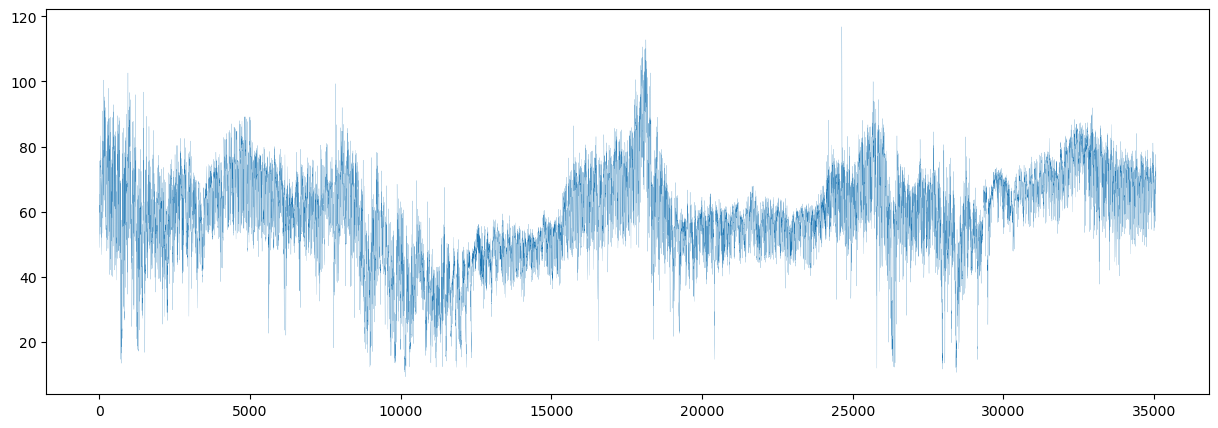

In [10]:
# Plot actual price. 
plt.figure(figsize=(15,5))
df['price actual'].plot(kind='line', lw=0.1);

In [11]:
forecast_df.head()

,time,price actual
0,2015-01-01 00:00:00,65.41
1,2015-01-01 01:00:00,64.92
2,2015-01-01 02:00:00,64.48
3,2015-01-01 03:00:00,59.32
4,2015-01-01 04:00:00,56.04


In [12]:
#Check if the data is stationary
adfuller(forecast_df["price actual"])

(-9.147016232851216,
 2.750493484933774e-15,
 50,
 35013,
 {'1%': -3.4305367814665044,
  '5%': -2.8616225527935106,
  '10%': -2.566813940257257},
 160666.1000497846)

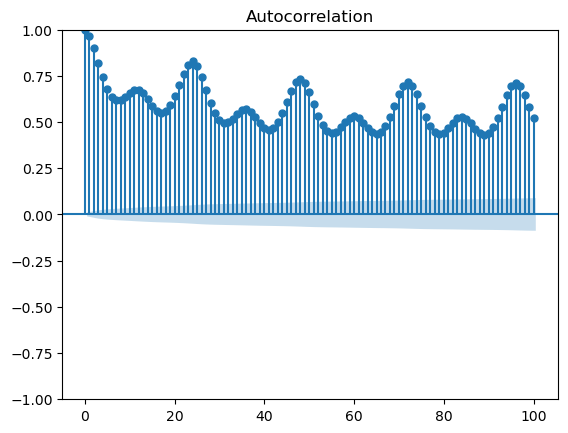

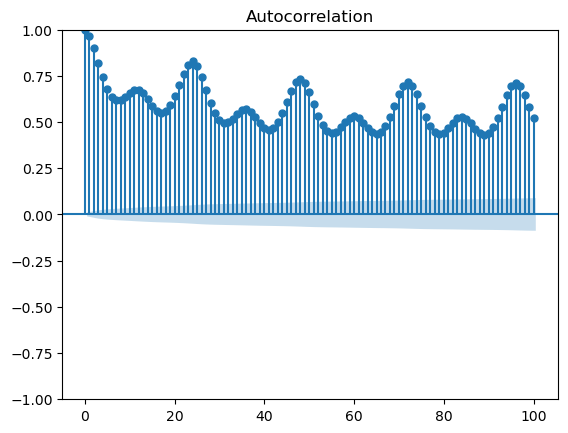

In [13]:
# Plot ACF. 
plot_acf(forecast_df["price actual"], lags=100)

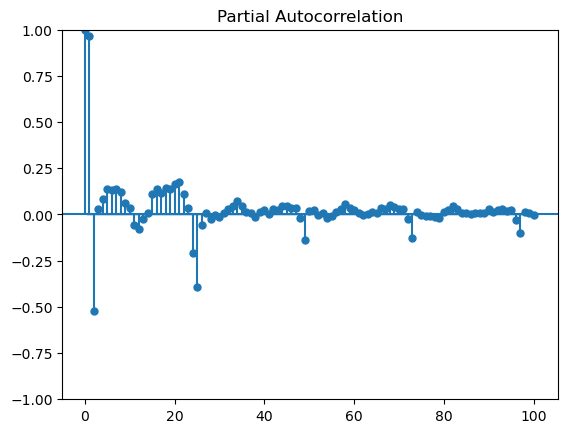

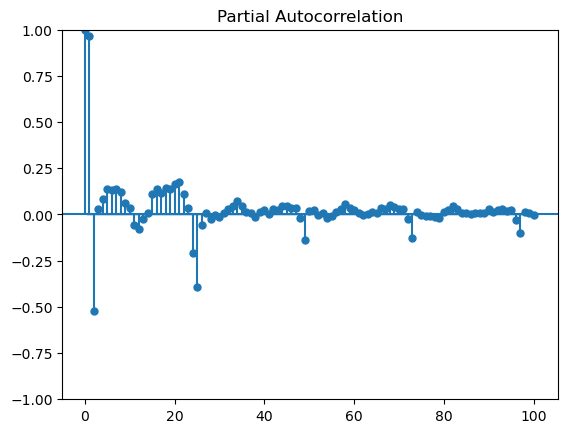

In [14]:
plot_pacf(forecast_df["price actual"], method='ywm', lags=100)

In [15]:
# Splitting the data into training and testing sets
train_size = 0.8  
train, test = train_test_split(forecast_df['price actual'], train_size=train_size, shuffle=False)


# Print the sizes of the training and testing sets
print("Train set size:", len(train))
print("Test set size:", len(test))

Train set size: 28051
Test set size: 7013


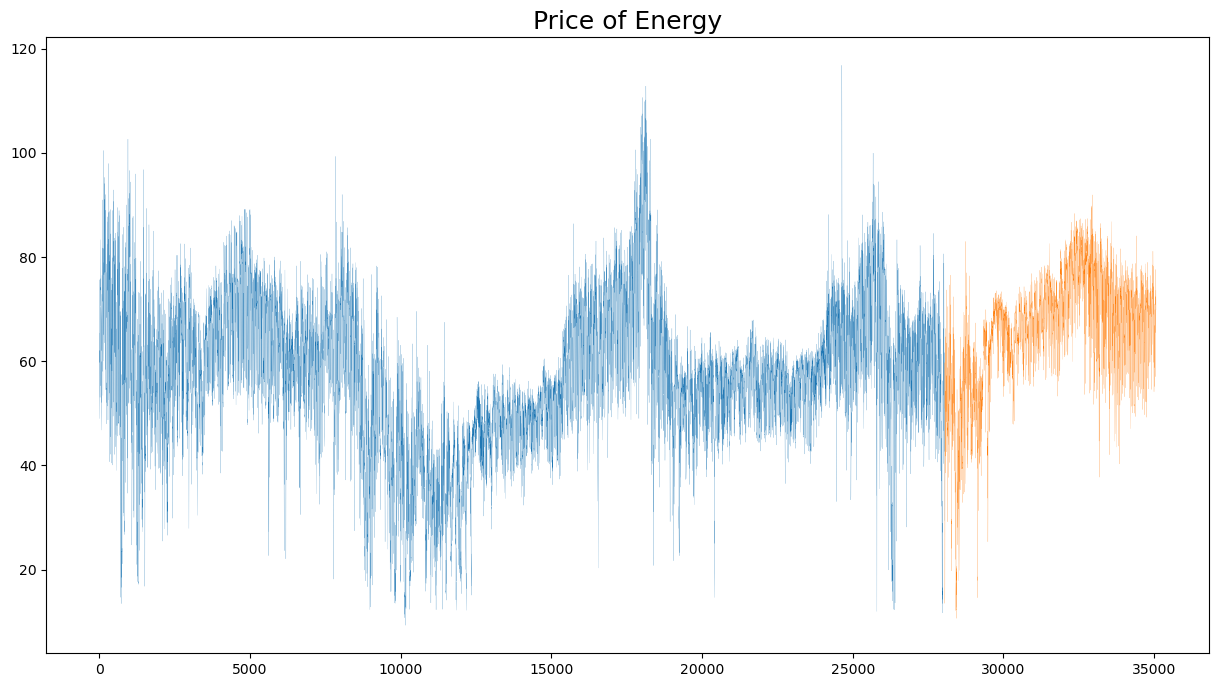

In [19]:
train.plot(figsize=(15,8), lw=0.1)
test.plot(figsize=(15,8), lw=0.1)
plt.title('Price of Energy', fontsize=18);

In [17]:
#aicVals = []
#for p in range(3):
#    for d in range(3):
 #       for q in range(3):
#            for P in range(3): 
 #               for D in range(3):  
 #                   for Q in range(3):  
 #                       print(f"p: {p}, d: {d}, q: {q}, P: {P}, D: {D}, Q: {Q}")
 #                       try:
 #                           model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, 12))
  #                          results = model.fit()
  #                          aic = results.aic
   #                         aicVals.append([aic, p, d, q, P, D, Q])
  #                      except:
  #                          continue

In [18]:
#aicVals.sort()

NameError: name 'aicVals' is not defined

In [ ]:
#aicVals

In [21]:
model = SARIMAX(train, order=(2, 0, 2), seasonal_order=(2, 0, 2, 12)).fit()

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       price actual   No. Observations:                28051
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 12)   Log Likelihood              -63866.909
Date:                            Fri, 17 Nov 2023   AIC                         127751.819
Time:                                    00:40:08   BIC                         127825.995
Sample:                                         0   HQIC                        127775.695
                                          - 28051                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8562      0.016    114.305      0.000       1.824       1.888
ar.L2         -0.8596      0.015    -55.494      0.000      -0.890      -0.829
ma.L1         -0.7385      0.016    -44.956      0.000      -0.771      -0.706
ma.L2         -0.1765      0.001   -144.877      0.000      -0.179      -0.174
ar.S.L12       0.0047      0.000      9.779      0.000       0.004       0.006
ar.S.L24       0.9951      0.000   2052.899      0.000       0.994       0.996
ma.S.L12       0.0020      0.001      1.583      0.113      -0.000       0.004
ma.S.L24      -0.8853      0.002   -390.544      0.000      -0.890      -0.881
sigma2         5.5491      0.020    274.233      0.000       5.509       5.589
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):             69397.16
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
forecast_values = model.get_forecast(steps=test.shape[0])

In [24]:
forecast_values

In [25]:
forecast_ci = forecast_values.conf_int()

In [26]:
forecast_values.predicted_mean

28051    36.812073
28052    40.098404
28053    38.455387
28054    34.401771
28055    30.664954
           ...    
35059    52.501784
35060    55.565901
35061    54.555761
35062    51.549294
35063    48.376563
Name: predicted_mean, Length: 7013, dtype: float64

In [27]:
from sklearn.metrics import mean_squared_error, r2_score

In [28]:
r2_score(forecast_values.predicted_mean, test)

-11.181980969691466